Valores de referência:
- top-tagging: accuracy > 0.9
- quark-gluon: acc. ~ 0.8

# Importar bibliotecas

In [1]:
import sys
sys.path.append('JetTagging')
sys.path.append('JetTagging/src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.Particle import ParticleType
from Preprocessing.JetPreprocessing import PreprocessingJetImages
from Preprocessing.LabelsGeneration import create_jet_labels_one_column_per_category
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPool2D #Dense = MPLNN
from keras.optimizers import Adam, schedules
from itertools import cycle

# Leitura de dados

In [2]:
data_gluon_train = pd.read_csv("../Dados/DataJetTagging/Trainning/g_jets.csv", header=None)
data_quark_train = pd.read_csv("../Dados/DataJetTagging/Trainning/q_jets.csv", header=None)
data_top_train = pd.read_csv("../Dados/DataJetTagging/Trainning/t_jets.csv", header=None)

data_gluon_val = pd.read_csv("../Dados/DataJetTagging/Validation/g_jets.csv", header=None)
data_quark_val = pd.read_csv("../Dados/DataJetTagging/Validation/q_jets.csv", header=None)
data_top_val = pd.read_csv("../Dados/DataJetTagging/Validation/t_jets.csv", header=None)

data_gluon_test = pd.read_csv("../Dados/DataJetTagging/Test/g_jets.csv", header=None)
data_quark_test = pd.read_csv("../Dados/DataJetTagging/Test/q_jets.csv", header=None)
data_top_test = pd.read_csv("../Dados/DataJetTagging/Test/t_jets.csv", header=None)

# Construção dos jatos e geração das imagens

In [3]:
jet_image_processing = PreprocessingJetImages(phi_range=(-0.3, 0.3), eta_range=(-0.3, 0.3), n_bins_phi=37, n_bins_eta=37)

In [30]:
top_images_train = jet_image_processing.transform(X=data_top_train.to_numpy())
quark_images_train = jet_image_processing.transform(X=data_quark_train.to_numpy())
gluon_images_train = jet_image_processing.transform(X=data_gluon_train.to_numpy())

top_images_val = jet_image_processing.transform(X=data_top_val.to_numpy())
quark_images_val = jet_image_processing.transform(X=data_quark_val.to_numpy())
gluon_images_val = jet_image_processing.transform(X=data_gluon_val.to_numpy())

top_images_test = jet_image_processing.transform(X=data_top_test.to_numpy())
quark_images_test = jet_image_processing.transform(X=data_quark_test.to_numpy())
gluon_images_test = jet_image_processing.transform(X=data_gluon_test.to_numpy())

In [32]:
all_jet_images_train = np.vstack([top_images_train, quark_images_train[: int(len(quark_images_train) / 2) + 1], gluon_images_train[: int(len(gluon_images_train)/2) + 1]])
all_jet_images_val = np.vstack([top_images_val, quark_images_val[: int(len(quark_images_val) / 2) + 1], gluon_images_val[: int(len(gluon_images_val)/2) + 1]])
all_jet_images_test = np.vstack([top_images_test, quark_images_test[: int(len(quark_images_test) / 2) + 1], gluon_images_test[: int(len(gluon_images_test)/2) + 1]])

In [33]:
jet_labels_train = create_jet_labels_one_column_per_category([(0, len(top_images_train) - 1), (len(top_images_train), len(all_jet_images_train) - 1)])
jet_labels_val = create_jet_labels_one_column_per_category([(0, len(top_images_val) - 1), (len(top_images_val), len(all_jet_images_val) - 1)])
jet_labels_test = create_jet_labels_one_column_per_category([(0, len(top_images_test) - 1), (len(top_images_test), len(all_jet_images_test) - 1)])

# Particionamento dos dados

In [34]:
x, y = shuffle(all_jet_images_train, jet_labels_train, random_state = 0)
vx, vy = shuffle(all_jet_images_val, jet_labels_val, random_state = 0)
tx, ty = shuffle(all_jet_images_test, jet_labels_test, random_state = 0)

x = x.reshape(-1,37,37,1)
vx = vx.reshape(-1,37,37,1)
tx = tx.reshape(-1,37,37,1)

# Construção da rede

In [35]:
#Montando a topologia da rede

nn1 = Sequential() #Rede sequencial
#especificamos as camadas da rede nn1
nn1.add(Input(shape=(37,37,1)))
nn1.add(Conv2D(filters = 128, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2)))
nn1.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2)))

# Aqui vai uma camada totalmente conectada
nn1.add(Flatten()) #Traduz uma matriz de várias dimensões em uma matriz linear (um vetor)
nn1.add(Dense(256, activation = "relu"))
nn1.add(Dense(256, activation = "relu"))
nn1.add(Dense(2, activation = "softmax"))
#topologia montada

# adicionando o otimizador
lr_schedule = schedules.ExponentialDecay(initial_learning_rate = 0.00005, decay_steps = 24650, decay_rate = 0.5, staircase = True)
optimizer = Adam(learning_rate=lr_schedule) #Adam é um backpropagation, mas com busca de mínimo otimizada

nn1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["categorical_accuracy", "auc"]) #Avisa o keras que essa é a nossa rede

In [8]:
epochs = 50
batch_size = 128

In [36]:
treino1 = nn1.fit(x,y, epochs = epochs, validation_data = (vx, vy), batch_size = batch_size )

Epoch 1/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 1542s 775ms/step - auc: 0.5010 - categorical_accuracy: 0.5065 - loss: 0.6931 - val_auc: 0.5056 - val_categorical_accuracy: 0.5056 - val_loss: 0.6931
Epoch 2/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 1500s 755ms/step - auc: 0.5044 - categorical_accuracy: 0.5044 - loss: 0.6931 - val_auc: 0.5056 - val_categorical_accuracy: 0.5056 - val_loss: 0.6931
Epoch 3/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 1497s 753ms/step - auc: 0.5057 - categorical_accuracy: 0.5057 - loss: 0.6931 - val_auc: 0.5056 - val_categorical_accuracy: 0.5056 - val_loss: 0.6931
Epoch 4/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 1468s 739ms/step - auc: 0.5073 - categorical_accuracy: 0.5073 - loss: 0.6930 - val_auc: 0.5056 - val_categorical_accuracy: 0.5056 - val_loss: 0.6931
Epoch 5/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 1470s 740ms/step - auc: 0.5055 - categorical_accuracy: 0.5055 - loss: 0.6931 - val_auc: 0.5056 - val_categorical_accuracy: 0.5056 - val_loss: 0.6931
Epoch 6/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 147

In [ ]:
file1 = 'top-tagger-37-1-1.keras'
nn1.save(file1)

# Avaliação da rede

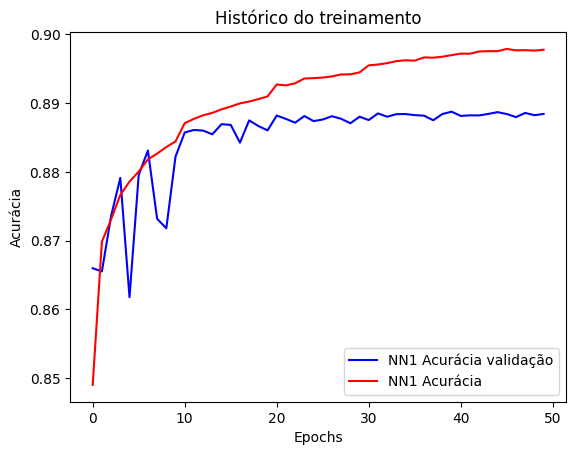

In [ ]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino1.history['val_categorical_accuracy'], color='b', label="NN1 Acurácia validação")
plt.plot(treino1.history['categorical_accuracy'], color='r', label="NN1 Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

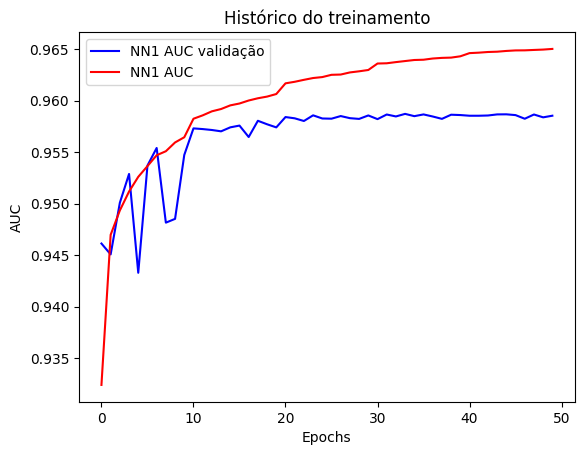

In [ ]:
# Plot the AUC and accuracy curves for training and validation
plt.plot(treino1.history['val_auc'], color='b', label="NN1 AUC validação")
plt.plot(treino1.history['auc'], color='r', label="NN1 AUC")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [ ]:
y_pred1 = nn1.predict(tx)

3287/3287 ━━━━━━━━━━━━━━━━━━━━ 171s 52ms/step


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ty[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

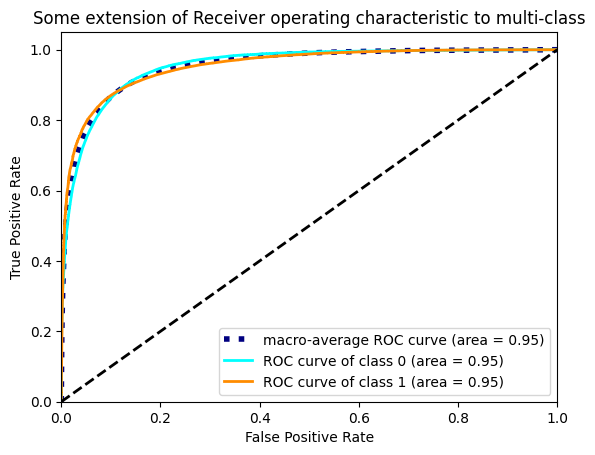

In [ ]:
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Redimensionalidade dos dados de entrada

In [ ]:
jet_image_processing_Dan = PreprocessingJetImages(phi_range=(-0.3, 0.3), eta_range=(-0.3, 0.3), n_bins_phi=16, n_bins_eta=16)

In [ ]:
gluon_images_train_D = jet_image_processing_Dan.transform(X=data_gluon_train.to_numpy())
quark_images_train_D = jet_image_processing_Dan.transform(X=data_quark_train.to_numpy())
top_images_train_D = jet_image_processing_Dan.transform(X=data_top_train.to_numpy())

gluon_images_val_D = jet_image_processing_Dan.transform(X=data_gluon_val.to_numpy())
quark_images_val_D = jet_image_processing_Dan.transform(X=data_quark_val.to_numpy())
top_images_val_D = jet_image_processing_Dan.transform(X=data_top_val.to_numpy())

gluon_images_test_D = jet_image_processing_Dan.transform(X=data_gluon_test.to_numpy())
quark_images_test_D = jet_image_processing_Dan.transform(X=data_quark_test.to_numpy())
top_images_test_D = jet_image_processing_Dan.transform(X=data_top_test.to_numpy())

In [ ]:
all_jet_images_train_D = np.vstack([gluon_images_train_D, quark_images_train_D, top_images_train_D])
all_jet_images_val_D = np.vstack((gluon_images_val_D, quark_images_val_D, top_images_val_D))
all_jet_images_test_D = np.vstack((gluon_images_test_D, quark_images_test_D, top_images_test_D))

In [ ]:
jet_labels_train_D = create_jet_labels_one_column_per_category([(0, len(gluon_images_train_D) + len(quark_images_train_D) - 1), (len(gluon_images_train_D) + len(quark_images_train_D), len(all_jet_images_train_D) - 1)])
jet_labels_val_D = create_jet_labels_one_column_per_category([(0, len(gluon_images_val_D) + len(quark_images_val_D) - 1), (len(gluon_images_val_D) + len(quark_images_val_D), len(all_jet_images_val_D) - 1)])
jet_labels_test_D = create_jet_labels_one_column_per_category([(0, len(gluon_images_test_D) + len(quark_images_test_D) - 1), (len(gluon_images_test_D) + len(quark_images_test_D), len(all_jet_images_test_D) - 1)])

In [ ]:
x_D, y_D = shuffle(all_jet_images_train_D, jet_labels_train_D, random_state = 0)
vx_D, vy_D = shuffle(all_jet_images_val_D, jet_labels_val_D, random_state = 0)
tx_D, ty_D = shuffle(all_jet_images_test_D, jet_labels_test_D, random_state = 0)

x_D = x_D.reshape(-1,16,16,1)
vx_D = vx_D.reshape(-1,16,16,1)
tx_D = tx_D.reshape(-1,16,16,1)

In [ ]:
#Montando a topologia da rede

nn2 = Sequential() #Rede sequencial
#especificamos as camadas da rede nn1
nn2.add(Input(shape=(16,16,1)))
nn2.add(Conv2D(filters = 128, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn2.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn2.add(MaxPool2D(pool_size=(2,2)))
nn2.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn2.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn2.add(MaxPool2D(pool_size=(2,2)))

# Aqui vai uma camada totalmente conectada
nn2.add(Flatten()) #Traduz uma matriz de várias dimensões em uma matriz linear (um vetor)
nn2.add(Dense(256, activation = "relu"))
nn2.add(Dense(256, activation = "relu"))
nn2.add(Dense(2, activation = "softmax"))
#topologia montada

# adicionando o otimizador
lr_schedule = schedules.ExponentialDecay(initial_learning_rate = 0.00005, decay_steps = 24650, decay_rate = 0.5, staircase = True)
optimizer = Adam(learning_rate=lr_schedule) #Adam é um backpropagation, mas com busca de mínimo otimizada

nn2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["categorical_accuracy", "auc"]) #Avisa o keras que essa é a nossa rede

In [ ]:
treino2 = nn2.fit(x_D,y_D, epochs = epochs, validation_data = (vx_D, vy_D), batch_size = batch_size )

Epoch 1/50
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 415s 140ms/step - auc: 0.9529 - categorical_accuracy: 0.8795 - loss: 0.2773 - val_auc: 0.9553 - val_categorical_accuracy: 0.8808 - val_loss: 0.2705
Epoch 2/50
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 419s 141ms/step - auc: 0.9539 - categorical_accuracy: 0.8805 - loss: 0.2745 - val_auc: 0.9482 - val_categorical_accuracy: 0.8695 - val_loss: 0.2933
Epoch 3/50
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 406s 137ms/step - auc: 0.9543 - categorical_accuracy: 0.8815 - loss: 0.2731 - val_auc: 0.9546 - val_categorical_accuracy: 0.8793 - val_loss: 0.2733
Epoch 4/50
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 407s 137ms/step - auc: 0.9549 - categorical_accuracy: 0.8816 - loss: 0.2714 - val_auc: 0.9548 - val_categorical_accuracy: 0.8824 - val_loss: 0.2716
Epoch 5/50
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 409s 138ms/step - auc: 0.9553 - categorical_accuracy: 0.8836 - loss: 0.2701 - val_auc: 0.9574 - val_categorical_accuracy: 0.8844 - val_loss: 0.2647
Epoch 6/50
2969/2969 ━━━━━━━━━━━━━━━━━━━━ 399s 134

In [ ]:
file2 = 'top-tagger-16-1-1.keras'
nn2.save(file2)

In [ ]:
#1/2 a 1/2
# Plot the loss and accuracy curves for training and validation
plt.plot(treino2.history['val_categorical_accuracy'], color='b', label="NN2 Acurácia validação")
plt.plot(treino2.history['categorical_accuracy'], color='r', label="NN2 Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

In [ ]:
#1/2 a 1/2
# Plot the loss and accuracy curves for training and validation
plt.plot(treino2.history['val_auc'], color='g', label="NN2 AUC validação")
plt.plot(treino2.history['auc'], color='y', label="NN2 AUC")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

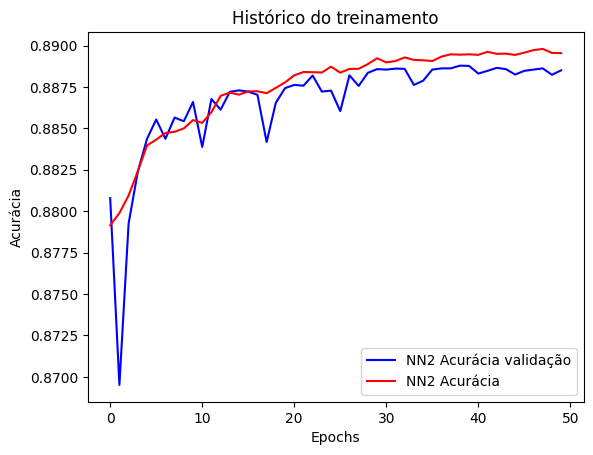

In [22]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino2.history['val_categorical_accuracy'], color='b', label="NN2 Acurácia validação")
plt.plot(treino2.history['categorical_accuracy'], color='r', label="NN2 Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

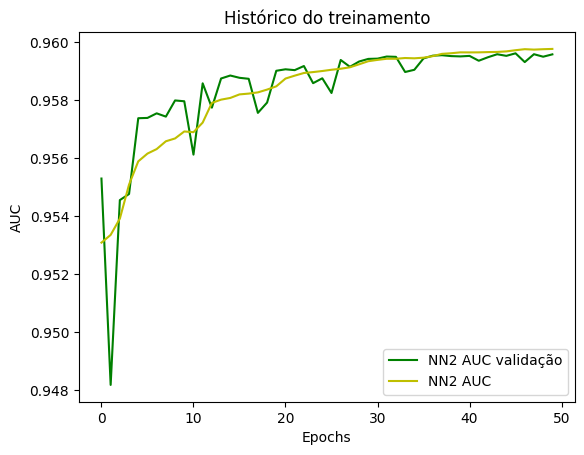

In [23]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino2.history['val_auc'], color='g', label="NN2 AUC validação")
plt.plot(treino2.history['auc'], color='y', label="NN2 AUC")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [ ]:
y_pred2 = nn2.predict(tx_D)

2466/2466 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ty_D[:, i], y_pred2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
#1/2  a 1/2
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

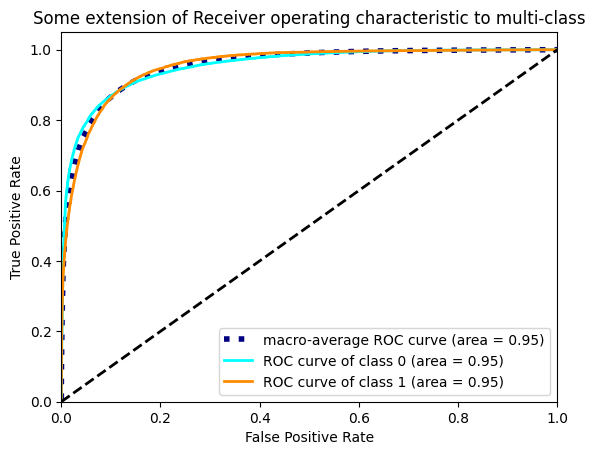

In [27]:
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()